In [9]:
!git clone https://github.com/biraaj/Caltech101-Airplanes-Motorbikes-Schooners.git

Cloning into 'Caltech101-Airplanes-Motorbikes-Schooners'...
remote: Enumerating objects: 1671, done.
remote: Counting objects: 100% (1671/1671), done.
remote: Compressing objects: 100% (1671/1671), done.
remote: Total 1671 (delta 1), reused 1667 (delta 0), pack-reused 0
Receiving objects: 100% (1671/1671), 14.24 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [60]:
#Importing Libraries

from torchvision import transforms, datasets, models
import torch
import torchvision
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.utils.data as data

In [61]:
#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
images_path = "/content/Caltech101-Airplanes-Motorbikes-Schooners/caltech101_classification"

In [63]:
#Applying Image Tranformations
transformer = transforms.Compose(
    [
        transforms.Resize((224, 224)), # As vgg takes 244*244 input
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]  ## As reference to the imagenet mean and std standard practice.
        ),
    ]
)
dataset = ImageFolder(images_path, transform=transformer)

In [64]:
# Here the classes are recognized according to folder structure if we use ImageFolder from torchvison.
total_class = dataset.classes
print(total_class)

['Motorbikes', 'airplanes', 'schooner']


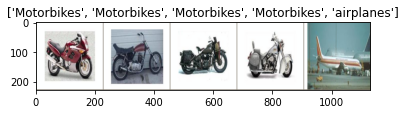

In [65]:
# Viewing Image After Transformation
def show_image(_input, _classes=None):
    input = _input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if _classes is not None:
        plt.title(_classes)
    plt.pause(0.002)

dataloader_to_view = data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=10)

# Getting samples of dataset
inputs, classes = next(iter(dataloader_to_view))

output_image_prepreprocessed = torchvision.utils.make_grid(inputs)

show_image(output_image_prepreprocessed, _classes=[total_class[y] for y in classes])

In [66]:
# Random split (train:6 valid:2 test:2)
train_set_size = int(len(dataset) * 0.6)
valid_set_size = int(len(dataset)*0.2)
test_set_size = valid_set_size + 1

In [67]:
print(train_set_size,valid_set_size,test_set_size)

996 332 333


In [68]:
train_set, valid_set, test_set = data.random_split(dataset, [train_set_size, valid_set_size, test_set_size])

In [73]:
# Training Sampler
## Collecting all the indices that the training set contains.
train_indices = train_set.indices

#Collecting the list with image target['Motorbikes':0, 'airplanes':1, 'schooner':2]
train_list = [dataset.targets[i] for i in train_indices]

# Sample count for each class([478 480 38])
train_class_sample_count = np.array(
    [len(np.where(train_list == t)[0]) for t in np.unique(train_list)])

In [80]:
# Finding weight of each class
train_weight = 1/ train_class_sample_count

# Assigning weight to each index
train_samples_weight = np.array([train_weight[t] for t in train_list])
train_samples_weight = torch.from_numpy(train_samples_weight)

In [81]:
# Validation Sampler
valid_indices = valid_set.indices

valid_list = [dataset.targets[i] for i in valid_indices]

valid_class_sample_count = np.array(
    [len(np.where(valid_list == t)[0]) for t in np.unique(valid_list)])

In [82]:
valid_weight = 1/ valid_class_sample_count
valid_samples_weight = np.array([valid_weight[t] for t in valid_list])
valid_samples_weight = torch.from_numpy(valid_samples_weight)

In [83]:
train_sampler = WeightedRandomSampler(train_samples_weight.type('torch.DoubleTensor'), len(train_samples_weight))

In [84]:
valid_sampler = WeightedRandomSampler(valid_samples_weight.type('torch.DoubleTensor'), len(valid_samples_weight))

In [85]:
# Loading data into RAM
train_dataloader = data.DataLoader(train_set, batch_size=4, sampler=train_sampler)
valid_dataloader = data.DataLoader(valid_set, batch_size=4, sampler=valid_sampler)
test_dataloader = data.DataLoader(test_set, batch_size=4)

In [133]:
# VGG16
class VGG16(nn.Module):
    def __init__(self, classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, classes))
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = self.layer5(res)
        res = self.layer6(res)
        res = self.layer7(res)
        res = self.layer8(res)
        res = self.layer9(res)
        res = self.layer10(res)
        res = self.layer11(res)
        res = self.layer12(res)
        res = self.layer13(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [185]:
class VGG19(nn.Module):
    def __init__(self, classes=10):
        super(VGG19, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer14 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU())
        self.layer15 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU())
        self.layer16 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, classes))
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = self.layer5(res)
        res = self.layer6(res)
        res = self.layer7(res)
        res = self.layer8(res)
        res = self.layer9(res)
        res = self.layer10(res)
        res = self.layer11(res)
        res = self.layer12(res)
        res = self.layer13(res)
        res = self.layer14(res)
        res = self.layer15(res)
        res = self.layer16(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [186]:
# Hyper parameter Tuning

classes = 3
epochs = 10
batch_size = 4
learning_rate = 0.005

#model = VGG16(num_classes).to(device)
model = VGG19(classes).to(device)
#model =torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=False)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


In [94]:
dir(train_dataloader)
len(train_dataloader.dataset)

996

In [187]:
# Training the model


total_step = len(train_dataloader)

for epoch in tqdm(range(epochs)):
    for i, (images, labels) in tqdm(enumerate(train_dataloader)):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(valid_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('model accuracy on {} validation images = {} %'.format(332, 100 * correct / total)) 

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/10], Step [249/249], Loss: 0.7478


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 53.6144578313253 %


0it [00:00, ?it/s]

Epoch [2/10], Step [249/249], Loss: 0.5745


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 50.0 %


0it [00:00, ?it/s]

Epoch [3/10], Step [249/249], Loss: 0.9128


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 77.40963855421687 %


0it [00:00, ?it/s]

Epoch [4/10], Step [249/249], Loss: 0.0746


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 86.144578313253 %


0it [00:00, ?it/s]

Epoch [5/10], Step [249/249], Loss: 0.0112


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 87.34939759036145 %


0it [00:00, ?it/s]

Epoch [6/10], Step [249/249], Loss: 0.0001


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.66265060240964 %


0it [00:00, ?it/s]

Epoch [7/10], Step [249/249], Loss: 0.0046


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 91.26506024096386 %


0it [00:00, ?it/s]

Epoch [8/10], Step [249/249], Loss: 0.0093


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 89.4578313253012 %


0it [00:00, ?it/s]

Epoch [9/10], Step [249/249], Loss: 0.0011


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 91.26506024096386 %


0it [00:00, ?it/s]

Epoch [10/10], Step [249/249], Loss: 0.0036


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 91.56626506024097 %


In [191]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('model accuracy on the {} test images: {} %'.format(333, 100 * correct / total))   

model accuracy on the 333 test images: 94.5945945945946 %
